# USING CLOSED LOOP DESIGNER

This notebook contains a case study of using SISOClosedLoopDesigner


In [1]:
import controlSBML as ctl
from controlSBML import constants as cn
from controlSBML import util
from controlSBML.sbml_system import SBMLSystem

import control
import lmfit
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sympy
import tellurium as te
ctl.__version__

'1.0.11'

In [2]:
TIMES = np.linspace(0, 20, 200)

# Models

## Linear

In [3]:
LINEAR_MDL = """
species S3

 -> S1; k0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 0
S2 = 0
S3 = 0
k0 = 0
k1 = 1
k2 = 2
k3 = 3
"""

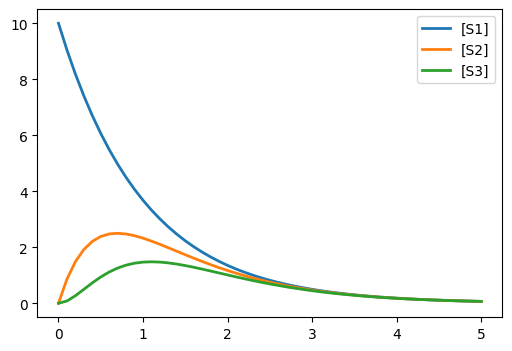

In [4]:
LINEAR_CTLSB = ctl.ControlSBML(LINEAR_MDL, input_names=["k0"], output_names=["S3"])
LINEAR_BLDR = LINEAR_CTLSB.makeSISOTransferFunctionBuilder(is_fixed_input_species=True)
selections = ["[S%d]" % (n+1) for n in range(3)]
selections.insert(0, "time")
LINEAR_CTLSB.roadrunner.reset()
LINEAR_CTLSB.roadrunner["S1"] = 10
data = LINEAR_CTLSB.roadrunner.simulate(selections=selections)
LINEAR_CTLSB.roadrunner.plot()

# System Identification

## Linear Model

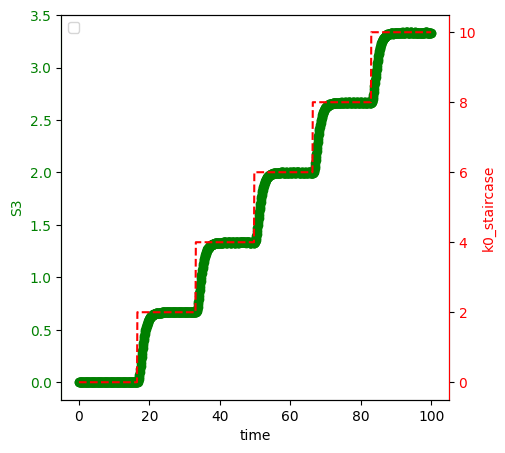

In [5]:
LINEAR_STAIRCASE = ctl.Staircase(initial_value=0, final_value=10, num_step=5)
response_ts = LINEAR_BLDR.makeStaircaseResponse(staircase=LINEAR_STAIRCASE, end_time=100)
_ = LINEAR_BLDR.plotStaircaseResponse(response_ts, figsize=(5,5))

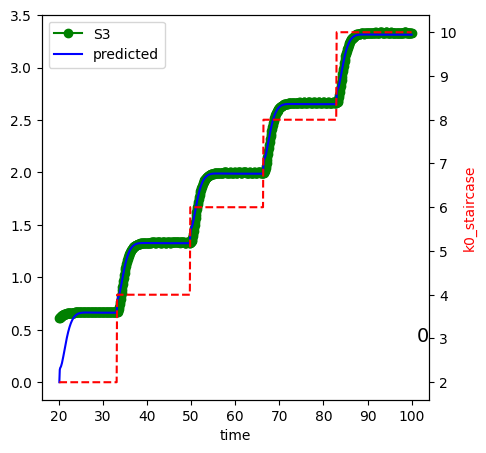

In [6]:
fitter_result = LINEAR_BLDR.fitTransferFunction(num_numerator=3, num_denominator=4, 
                                                      staircase=LINEAR_STAIRCASE, fit_start_time=20,
                                                start_time=0, end_time=100)
_ = LINEAR_BLDR.plotFitTransferFunction(fitter_result, figsize=(5,5))
LINEAR_TF = fitter_result.transfer_function

In [7]:
LINEAR_TF

TransferFunction(array([0.00048804, 0.0006561 , 0.00274681]), array([0.00035388, 0.00749284, 0.01358634, 0.0082879 ]))

# Testbed Construction

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

In [8]:
siso = ctl.SISOClosedLoopSystem(LINEAR_CTLSB)
#siso.makePIDClosedLoopSystem(kp=0.5, ki=0.2, closed_loop_outputs=["S1", "S3"])
siso.makePIDClosedLoopSystem(kp=1, ki=1, closed_loop_outputs=["S1", "S3"])

In [9]:
end_time =50
result_ts = siso.makeResponse(times=TIMES, step_size=5)

Text(0, 0.5, 'S3')

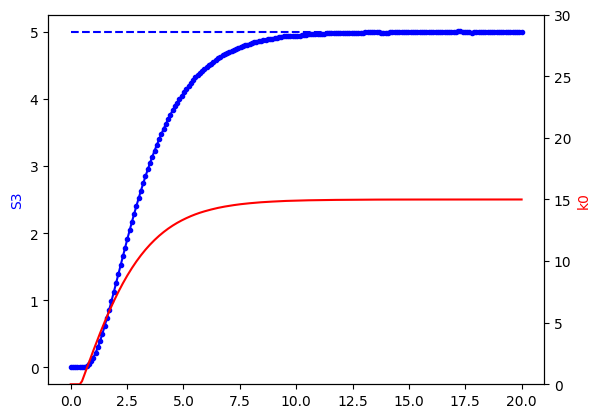

In [10]:
df = result_ts.copy()
times = np.array(df.index)/1000
plt.plot(TIMES, df["S3"], color="blue", marker=".")
ax = plt.gca()
ax.plot(TIMES, result_ts["reference"], linestyle="--", color = "blue")
ax2 = ax.twinx()
ax2.plot(TIMES, result_ts["S1"], color="red")
ax2.set_ylim([0, 30])
ax2.set_ylabel("k0", color="red")
ax.set_ylabel("S3", color="blue")
#_ = ax.set_ylim([0, 5000])

# Closed Loop Design and Evaluation

**BUG**
1. Why is designer so bad? I don't believe the poles for the design parameters.

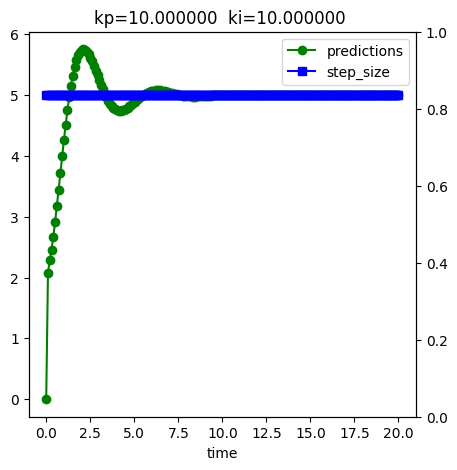

In [11]:
designer = ctl.SISOClosedLoopDesigner(LINEAR_TF, times=TIMES, step_size=5)
designer.design( kp=True, ki=True)
designer.set(kp=10, ki=10)
designer.plot(figsize=(5,5), times=TIMES)  # Have options for a period

In [12]:
designer.closed_loop_tf.poles()

array([-32.92426765+0.j        ,  -0.55361273+1.49035571j,
        -0.55361273-1.49035571j,  -0.9326914 +0.j        ])

In [13]:
designer.residual_rmse

0.3546701128781505

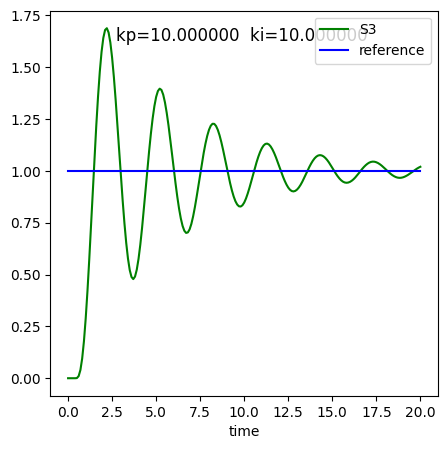

In [14]:
designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, is_fixed_input_species=True,
                                             figsize=(5,5))

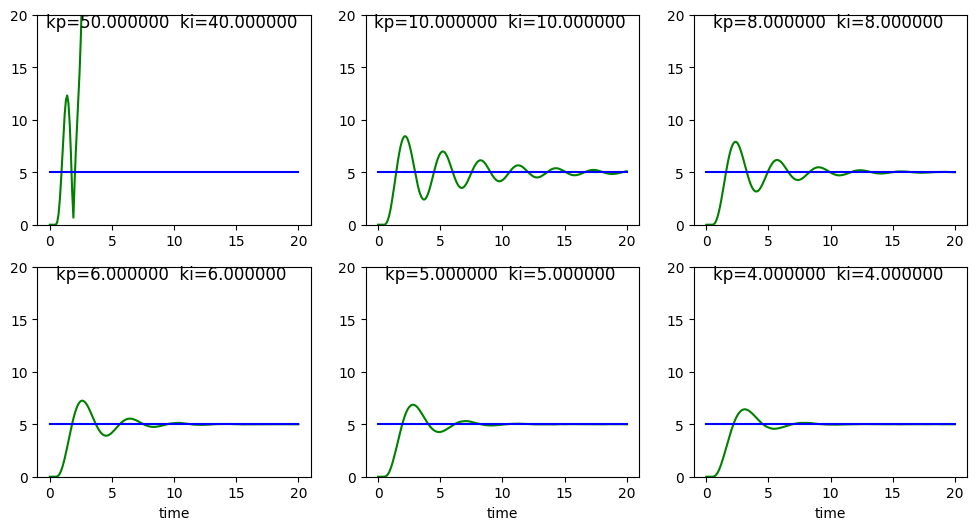

In [15]:
nrow = 2
ncol = 3
_, axes = plt.subplots(nrow, ncol)
icol = 0
irow = 0
for dct in [dict(kp=50, ki=40), dict(kp=10, ki=10), dict(kp=8, ki=8), dict(kp=6, ki=6), dict(kp=5, ki=5), dict(kp=4, ki=4)]:
    ax = axes[irow, icol]
    designer.set(**dct)
    if (icol == icol - 1) and (irow == irow - 1):
        is_plot = True
    else:
        is_plot = False
    designer.evaluateNonlinearIOSystemClosedLoop(LINEAR_CTLSB, times=TIMES, is_fixed_input_species=True,
                                             figsize=(12, 6), ylim=[0, 20], ax=ax, legend=False, is_plot=is_plot,
                                                step_size=5)
    if irow < nrow - 1:
        ax.set_xlabel("")
    if icol == ncol - 1:
        icol = 0
        irow += 1
    else:
        icol += 1

# Manual construction of feedback loop

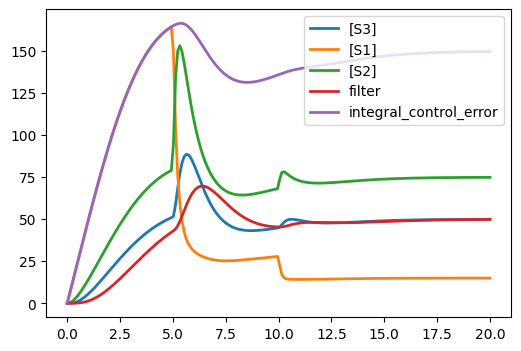

In [16]:
# Control k0
LINEAR_FEEDBACK = """

input := S3
filter' = -kf*filter + kf*input
control_error := reference - filter
integral_control_error' = control_error
control_input := kp*control_error + ki*integral_control_error
k0 := control_input
species S3
//
 -> S1; k0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S1 = 0
S2 = 0
S3 = 0
#k0 = 1
k1 = 1
k2 = 2
k3 = 3
kp = 1
ki = 1
kf = 1
integral_control_error = 0
filter = 0
#
reference = 50

at (time >= 5): k1 = 5
at (time > 10): k1 = 10
"""
rr = te.loada(LINEAR_FEEDBACK)
data = rr.simulate(0, 20, 200)
rr.plot()

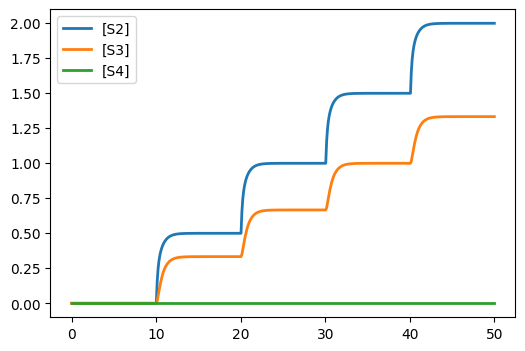

In [17]:
model2="""species S1, S2, S3, S4;

// Reactions:
_J0: S1 -> S2; k1*S1;
J1: S2 -> S3; k2*S2;
J2: S3 -> S2; k3*S3;
J3: S2 -> ; k4*S2;

// Species initializations:
S1 = 10;
S2 = 0;
S3 = 0;
S4 = ;

// Variable initializations:
k1 = 1;
k2 = 2;
k3 = 3;
k4 = 4;

// Other declarations:
const k1, k2, k3, k4;


//--------------Aded by ControlSBML-----------------
// Staircase: S1->S3
const S1
S1 = 0
at (time>= 0.0): S1 = 0.0
at (time>= 10.02004008016032): S1 = 2.0
at (time>= 20.04008016032064): S1 = 4.0
at (time>= 30.060120240480963): S1 = 6.0
at (time>= 40.08016032064128): S1 = 8.0"""
rr = te.loada(model2)
data = rr.simulate(0, 50, 500)
rr.plot()

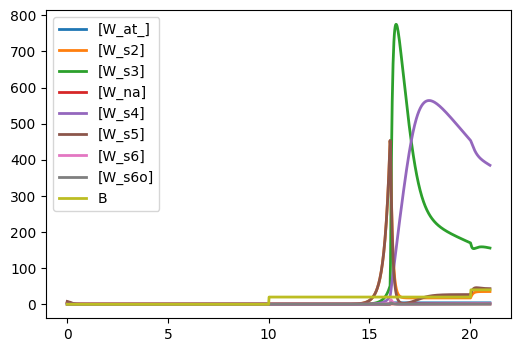

In [18]:
import roadrunner
MODEL = """
model *Wolf2000_Glycolytic_Oscillations()
  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_
  species at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;
  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;
  // Species initializations:
  s1 = 1;
  at_ = 2;
  s2 = 5;
  s3 = 0.6;
  na = 0.6;
  s4 = 0.7;
  s5 = 8;
  s6 = 0.08;
  s6o = 0.02;
  // Compartment initializations:
  compartment_ = 1;
  // Variable initializations:
  k0 = 50;
  k0 has mM_min_1;
  k1 = 550;
  k1 has mM_1_min_1;
  k2 = 9.8;
  k2 has min_1;
  k31 = 323.8;
  k31 has mM_1_min_1;
  k33 = 57823.1;
  k33 has mM_1_min_1;
  k32 = 76411.1;
  k32 has mM_1_min_1;
  k34 = 23.7;
  k34 has mM_1_min_1;
  k4 = 80;
  k4 has mM_1_min_1;
  k5 = 9.7;
  k5 has min_1;
  k6 = 2000;
  k6 has mM_1_min_1;
  k7 = 28;
  k7 has min_1;
  k8 = 85.7;
  k8 has mM_1_min_1;
  k9 = 80;
  k9 has min_1;
  k10 = 375;
  k10 has min_1;
  atot = 4;
  atot has mM;
  ntot = 1;
  ntot has mM;
  n = 4;
  n has dimensionless;
  ki = 1;
  ki has mM;
  // Other declarations:
  const compartment_, k0, k1, k2, k31, k33, k32, k34, k4, k5, k6, k7, k8;
  const k9, k10, atot, ntot, n, ki;
  // Unit definitions:
  unit substance = 1e-3 mole;
  unit time_unit = 60 second;
  unit mM = 1e-3 mole / litre;
  unit mM_min_1 = 1e-3 mole / (litre * 60 second);
  unit min_1 = 1 / 60 second;
  unit mM_1_min_1 = litre / (1e-3 mole * 60 second);
  // Display Names:
  substance is "milli mole";
  time_unit is "min";
  compartment_ is "compartment";
  s1 is "Glucose";
  at_ is "ATP";
  s2 is "F16P";
  s3 is "Triose_Gly3Phos_DHAP";
  na is "NAD";
  s4 is "3PG";
  s5 is "Pyruvate";
  s6 is "Acetaldehyde";
  s6o is "extracellular acetaldehyde";
  // CV terms:
  s1 identity "http://identifiers.org/obo.chebi/CHEBI:17234",
              "http://identifiers.org/kegg.compound/C00293"
  at_ identity "http://identifiers.org/obo.chebi/CHEBI:15422",
               "http://identifiers.org/kegg.compound/C00002"
  s2 identity "http://identifiers.org/obo.chebi/CHEBI:16905",
              "http://identifiers.org/kegg.compound/C05378"
  s3 part "http://identifiers.org/obo.chebi/CHEBI:16108",
          "http://identifiers.org/obo.chebi/CHEBI:29052",
          "http://identifiers.org/kegg.compound/C00111",
          "http://identifiers.org/kegg.compound/C00118"
  na identity "http://identifiers.org/obo.chebi/CHEBI:15846",
              "http://identifiers.org/kegg.compound/C00003"
  s4 identity "http://identifiers.org/obo.chebi/CHEBI:17794",
              "http://identifiers.org/kegg.compound/C00197"
  s5 identity "http://identifiers.org/kegg.compound/C00022",
              "http://identifiers.org/chebi/CHEBI:32816"
  s5 identity "http://identifiers.org/obo.chebi/CHEBI:15361"
  s6 identity "http://identifiers.org/obo.chebi/CHEBI:15343",
              "http://identifiers.org/kegg.compound/C00084"
  s6o identity "http://identifiers.org/obo.chebi/CHEBI:15343",
               "http://identifiers.org/kegg.compound/C00084"
  v1 part "http://identifiers.org/kegg.reaction/R00756",
          "http://identifiers.org/kegg.reaction/R00299"
  v1 part "http://identifiers.org/ec-code/2.7.1.11",
          "http://identifiers.org/ec-code/5.3.1.9"
  v2 identity "http://identifiers.org/ec-code/4.1.2.13",
              "http://identifiers.org/kegg.reaction/R01070"
  v3 part "http://identifiers.org/ec-code/2.7.2.3",
          "http://identifiers.org/ec-code/1.2.1.12"
  v4 part "http://identifiers.org/kegg.reaction/R00658",
          "http://identifiers.org/kegg.reaction/R00200"
  v4 part "http://identifiers.org/ec-code/2.7.1.40"
  v5 hypernym "http://identifiers.org/ec-code/4.1.1.1",
              "http://identifiers.org/kegg.reaction/R00224"
  v7 hypernym "http://identifiers.org/obo.go/GO:0006754"
  v8 part "http://identifiers.org/kegg.reaction/R05679"
  v9 hypernym "http://identifiers.org/obo.go/GO:0046187"
  v6 hypernym "http://identifiers.org/ec-code/1.1.1.71",
              "http://identifiers.org/kegg.reaction/R00754"
  v0 hypernym "http://identifiers.org/obo.go/GO:0046323"
end
Wolf2000_Glycolytic_Oscillations is "Wolf2000_Glycolytic_Oscillations"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/MODEL3352181362"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000206"
Wolf2000_Glycolytic_Oscillations description "http://identifiers.org/pubmed/10692304"
Wolf2000_Glycolytic_Oscillations taxon "http://identifiers.org/taxonomy/4932"
Wolf2000_Glycolytic_Oscillations hypernym "http://identifiers.org/obo.go/GO:0006096"
Wolf2000_Glycolytic_Oscillations identity "http://identifiers.org/kegg.pathway/sce00010"
//--------------Aded by ControlSBML-----------------
model *New()
W: Wolf2000_Glycolytic_Oscillations()
const W.s1
B is W.s1
// Staircase: s1->s6
species B = 0.000000
at (time>= 0.0): B = 0.0
at (time>= 10.02004008016032): B = 20.0
at (time>= 20.04008016032064): B = 40.0
at (time>= 30.060120240480963):B = 60.0
at (time>= 40.08016032064128):B = 80.0
end
"""



rr = te.loada(MODEL)
sels = rr.selections
sels.append("B")
rr.selections = sels
rr.simulate(0, 21, 1000)
rr.plot()

In [19]:
names = ["s1", "s6"]
system = SBMLSystem(MODEL, [names[0]], [names[1]], is_fixed_input_species=True)
times = np.linspace(0, 50, 500)
ts = system.simulateStaircase(names[0], names[1], times=times, final_value=100, num_step=5, is_steady_state=False)
for column in ts.columns:
    if not column in names:
        del ts[column]
util.plotOneTS(ts, ax2=0, figsize=(20,8))
plt.show()

Exception: Antimony: Unable to read SBML string due to errors encountered when parsing the file.  Error(s) from libSBML:

line 178: (10313 [Error]) Unit identifier references (i.e the 'units' attribute on <Compartment>, the 'units' attribute on <Parameter>, and the 'substanceUnits' attribute on <Species>) must be the identifier of a <UnitDefinition> in the <Model>, or the identifier of a predefined unit in SBML.
 The units 'W_dimensionles' of the <parameter> with id 'W_n' do not refer to a valid unit kind/built-in unit or the identifier of an existing <unitDefinition>. 



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 23 17:51:58 2023

@author: Lucian
"""

import tellurium as te
import roadrunner

r = te.loada("""
// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()
  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_
  species at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;
  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;
  // Species initializations:
  s1 = 1;
  at_ = 2;
  s2 = 5;
  s3 = 0.6;
  na = 0.6;
  s4 = 0.7;
  s5 = 8;
  s6 = 0.08;
  s6o = 0.02;
  // Compartment initializations:
  compartment_ = 1;
  // Variable initializations:
  k0 = 50;
  k0 has mM_min_1;
  k1 = 550;
  k1 has mM_1_min_1;
  k2 = 9.8;
  k2 has min_1;
  k31 = 323.8;
  k31 has mM_1_min_1;
  k33 = 57823.1;
  k33 has mM_1_min_1;
  k32 = 76411.1;
  k32 has mM_1_min_1;
  k34 = 23.7;
  k34 has mM_1_min_1;
  k4 = 80;
  k4 has mM_1_min_1;
  k5 = 9.7;
  k5 has min_1;
  k6 = 2000;
  k6 has mM_1_min_1;
  k7 = 28;
  k7 has min_1;
  k8 = 85.7;
  k8 has mM_1_min_1;
  k9 = 80;
  k9 has min_1;
  k10 = 375;
  k10 has min_1;
  atot = 4;
  atot has mM;
  ntot = 1;
  ntot has mM;
  n = 4;
  n has dimensionless;
  ki = 1;
  ki has mM;
  // Other declarations:
  const compartment_, k0, k1, k2, k31, k33, k32, k34, k4, k5, k6, k7, k8;
  const k9, k10, atot, ntot, n, ki;
  // Unit definitions:
  unit substance = 1e-3 mole;
  unit time_unit = 60 second;
  unit mM = 1e-3 mole / litre;
  unit mM_min_1 = 1e-3 mole / (litre * 60 second);
  unit min_1 = 1 / 60 second;
  unit mM_1_min_1 = litre / (1e-3 mole * 60 second);
  // Display Names:
  substance is "milli mole";
  time_unit is "min";
  compartment_ is "compartment";
  s1 is "Glucose";
  at_ is "ATP";
  s2 is "F16P";
  s3 is "Triose_Gly3Phos_DHAP";
  na is "NAD";
  s4 is "3PG";
  s5 is "Pyruvate";
  s6 is "Acetaldehyde";
  s6o is "extracellular acetaldehyde";
  // CV terms:
  s1 identity "http://identifiers.org/obo.chebi/CHEBI:17234",
              "http://identifiers.org/kegg.compound/C00293"
  at_ identity "http://identifiers.org/obo.chebi/CHEBI:15422",
               "http://identifiers.org/kegg.compound/C00002"
  s2 identity "http://identifiers.org/obo.chebi/CHEBI:16905",
              "http://identifiers.org/kegg.compound/C05378"
  s3 part "http://identifiers.org/obo.chebi/CHEBI:16108",
          "http://identifiers.org/obo.chebi/CHEBI:29052",
          "http://identifiers.org/kegg.compound/C00111",
          "http://identifiers.org/kegg.compound/C00118"
  na identity "http://identifiers.org/obo.chebi/CHEBI:15846",
              "http://identifiers.org/kegg.compound/C00003"
  s4 identity "http://identifiers.org/obo.chebi/CHEBI:17794",
              "http://identifiers.org/kegg.compound/C00197"
  s5 identity "http://identifiers.org/kegg.compound/C00022",
              "http://identifiers.org/chebi/CHEBI:32816"
  s5 identity "http://identifiers.org/obo.chebi/CHEBI:15361"
  s6 identity "http://identifiers.org/obo.chebi/CHEBI:15343",
              "http://identifiers.org/kegg.compound/C00084"
  s6o identity "http://identifiers.org/obo.chebi/CHEBI:15343",
               "http://identifiers.org/kegg.compound/C00084"
  v1 part "http://identifiers.org/kegg.reaction/R00756",
          "http://identifiers.org/kegg.reaction/R00299"
  v1 part "http://identifiers.org/ec-code/2.7.1.11",
          "http://identifiers.org/ec-code/5.3.1.9"
  v2 identity "http://identifiers.org/ec-code/4.1.2.13",
              "http://identifiers.org/kegg.reaction/R01070"
  v3 part "http://identifiers.org/ec-code/2.7.2.3",
          "http://identifiers.org/ec-code/1.2.1.12"
  v4 part "http://identifiers.org/kegg.reaction/R00658",
          "http://identifiers.org/kegg.reaction/R00200"
  v4 part "http://identifiers.org/ec-code/2.7.1.40"
  v5 hypernym "http://identifiers.org/ec-code/4.1.1.1",
              "http://identifiers.org/kegg.reaction/R00224"
  v7 hypernym "http://identifiers.org/obo.go/GO:0006754"
  v8 part "http://identifiers.org/kegg.reaction/R05679"
  v9 hypernym "http://identifiers.org/obo.go/GO:0046187"
  v6 hypernym "http://identifiers.org/ec-code/1.1.1.71",
              "http://identifiers.org/kegg.reaction/R00754"
  v0 hypernym "http://identifiers.org/obo.go/GO:0046323"
end

Wolf2000_Glycolytic_Oscillations is "Wolf2000_Glycolytic_Oscillations"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/MODEL3352181362"
Wolf2000_Glycolytic_Oscillations model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000206"
Wolf2000_Glycolytic_Oscillations description "http://identifiers.org/pubmed/10692304"
Wolf2000_Glycolytic_Oscillations taxon "http://identifiers.org/taxonomy/4932"
Wolf2000_Glycolytic_Oscillations hypernym "http://identifiers.org/obo.go/GO:0006096"
Wolf2000_Glycolytic_Oscillations identity "http://identifiers.org/kegg.pathway/sce00010"

//--------------Aded by ControlSBML-----------------
model *New()
W: Wolf2000_Glycolytic_Oscillations()
const W.s1
B is W.s1
// Staircase: s1->s6
species B = 0.000000
at (time>= 0.0): B = 0.0
at (time>= 10.02004008016032): B = 20.0
at (time>= 20.04008016032064): B = 40.0
at (time>= 30.060120240480963):B = 60.0
at (time>= 40.08016032064128):B = 80.0
end
""")

sels = r.selections
sels.append("B")
r.selections = sels
r.simulate(0, 21, 1000)
r.plot()







In [ ]:
rr2 = te.loadSBMLModel(cn.MTOR_URL)
print (rr2.getAntimony())

In [ ]:
names = ["S1", "S3"]
system = SBMLSystem(LINEAR_MDL, [names[0]], [names[1]], is_fixed_input_species=True)
times = np.linspace(0, 50, 500)
ts = system.simulateStaircase(names[0], names[1], times=times, final_value=100, num_step=5, is_steady_state=False)
for column in ts.columns:
    if not column in names:
        del ts[column]
util.plotOneTS(ts, ax2=0, figsize=(20,8))
plt.show()

In [ ]:
system.antimony_builder

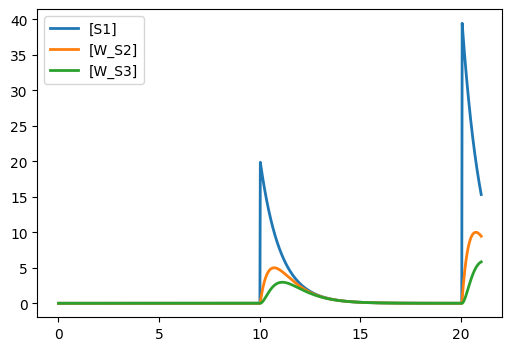

In [25]:
new_model = """// Created by libAntimony v2.13.2

model *main()
// Compartments and Species:
// compartment comp_;
//species S3 in comp_, S1 in comp_, S2 in comp_;
species S1, S2, S3

// Reactions:
_J0:  -> S1; k0;
_J1: S1 -> S2; k1*S1;
_J2: S2 -> S3; k2*S2;
_J3: S3 -> ; k3*S3;

// Species initializations:
S3 = 0;
S1 = 0;
S2 = 0;

// Variable initializations:
k0 = 0;
k1 = 1;
k2 = 2;
k3 = 3;

// Other declarations:
const k0, k1, k2, k3;
end

model *control_sbml()
//--------------Aded by ControlSBML-----------------
W: main()

W.S1 is S1
//species S1 in comp_; species S2 in comp_; species S3 in comp_;

// Staircase: S1->S3
S1 = 0.000000
at (time>= 0.0): S1 = 0.0
at (time>= 10.02004008016032): S1 = 20.0
at (time>= 20.04008016032064): S1 = 40.0
at (time>= 30.060120240480963): S1 = 60.0
at (time>= 40.08016032064128): S1 = 80.0
end


"""

r = te.loada(new_model)
sels = r.selections
#sels.extend(["S1", "S3"])
r.selections = sels
r.simulate(0, 21, 1000)
r.plot()




In [24]:
r.model.getModelName()

'__main'

In [31]:
model = """
// Illustrate Antimony File
model *main_model()
S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
S1 = 10
S2 = 0
S3 = 0
end


module *controlSBMLModel()
M: main_model()
M.S1 is S1
M.S2 is S2
M.S3 is S3

aa := S1

const S1
end
"""

rr = te.loada(model)
data = rr.simulate()

In [32]:
rr.getAssignmentRuleIds()

('aa',)